# SST (Spatial Stress Test) Behavioral Analysis

Data Collected June 2015

In [1]:
import pandas as pd
import moss
from scipy import stats
import scipy as sp
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path as op
import re

#widget ability
# from IPython.html.widgets import interact, interactive, fixed
# from IPython.html import widgets
# from IPython.display import clear_output, display, HTML
import ipywidgets
from ipywidgets import interact, interactive, fixed
from IPython.display import clear_output, display, HTML

import glob

# Gather project info & functions
from sst_setup_project import *

# for plotting
sns.set(style='whitegrid', context='poster')
%matplotlib inline

# R for stats
# %load_ext rpy2.ipython
# %R require(lme4)
# %R require(lmerTest)

/Users/sgagnon/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/sgagnon/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Set up directories & exp-specific information

In [2]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/SST')
dirs['navdir'] = op.join('/Volumes/group/awagner/sgagnon/SST/nav_data')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['basedir'], 'data', 'subj_info.csv')
dirs['shortcut_file'] = op.join(dirs['basedir'], 'data','shortcut_coords.csv')
dirs['order_file'] = op.join(dirs['basedir'], 'data','SST_env_order.csv')

In [3]:
proj = gather_experiment_info(exp_name='SST', dirs=dirs)

### Read in subject information

In [4]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info[['subid']] = subj_info.subid.astype(str)
subj_info

,subid,group,remove
1,2,control,NaN
2,3,control,NaN
3,4,control,NaN
4,5,control,NaN
5,6,control,NaN
6,7,control,NaN
7,9,control,NaN
9,11,control,NaN
10,12,control,NaN


In [5]:
shortcut_coords = pd.read_csv(dirs['shortcut_file'])
shortcut_coords

,env,x_lo,x_hi,y_lo,y_hi
0,env1,16,32,5,15
1,env2,8,28,28,48
2,env3,24,40,16,24
3,env4,16,32,16,24
4,env5,12,20,20,31
5,env6,24,40,24,40
6,env7,10,15,30,40
7,env8,16,32,0,16
8,env9,24,35,0,12
9,env10,48,56,24,40


## Read in data files

In [6]:
trial_order = pd.read_csv(dirs['order_file'])
trial_order[['subid']] = trial_order[['subid']].astype(str)
trial_order.head()

,subid,rep,run,trial,env
0,1,1,1,1,1
1,1,1,1,2,8
2,1,1,1,3,9
3,1,1,2,1,4
4,1,1,2,2,5


In [7]:
df = pd.DataFrame() # dataframe of subjs x envs
test = True
questionnaires_shock  = False
questionnaires_post  = True

test_types = ['habit', 'shortcut']

# iterate through subjects
for subid in subj_info.subid:
    print subid
    
    if test:
        # iterate through environments
        for run_num in range(1, 12+1):

            if int(subid) < 10:
                # add test file
                test_file = glob.glob(op.join(dirs['navdir'], 'sst0' + str(subid), 'run'+ str(run_num),
                                    'session_*', 'log.txt'))[0]
            else:
                test_file = glob.glob(op.join(dirs['navdir'], 'sst' + str(subid), 'run'+ str(run_num),
                                    'session_*', 'log.txt'))[0]
                
#             print test_file 
            
            output = []
            with open(test_file) as f:
                data = f.readlines()

                for line in data:
                    columns = re.split('\t|\r|\n', line)
                    output.append(columns)
                    
            d2 = pd.DataFrame(output, columns = ['time', 'c2', 'command', 
                                                 'c3', 'c4', 'c5', 'c6', 'c7', 'c8'])

            # include subid and env
            d2['subid'] = subid
            d2['run'] = run_num
                        
            if run_num < 5:
                d2['type'] = 'habit'
            else:
                d2['type'] = 'shortcut'

            # force time to be integer, diff from end to beginning
            d2.time = d2.time.astype(int)
            d2.time = d2.time - d2.time.min()

            df = df.append(d2, ignore_index=True)
        
# Compiled group data
if questionnaires_shock:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_shockblock_group.csv')
    dq_shock = pd.read_csv(q_file, index_col=0)

if questionnaires_post:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_group.csv')
    dq_post = pd.read_csv(q_file, index_col=0)
    dq_post['subid'] = dq_post.subid.astype(str)

2
3
4
5
6
7
9
11
12


## Look at data

In [8]:
df.head()

,time,c2,command,c3,c4,c5,c6,c7,c8,subid,run,type
0,0,1,COMMON_WIN_PROPERTIES,800,600,True,False,,,2,1,habit
1,125,0,CAMERA_INIT,PandaEPL_defaultCamera,,,None,None,None,2,1,habit
2,125,0,VR_INIT,,,None,None,None,None,2,1,habit
3,125,0,VR_CREATED,,,None,None,None,None,2,1,habit
4,2175,0,CONF_LOAD,./config.py,None,,,None,None,2,1,habit


## Integrate env labels

#### Any runs without 3 trials?

In [9]:
counts = pd.groupby(df[df.command == "ORIENT"], by=['subid', 'run']).count().reset_index()
counts[counts.command != 3]

,subid,run,time,c2,command,c3,c4,c5,c6,c7,c8,type
1,11,2,1,1,1,1,1,1,1,1,1,1


In [10]:
orient_onsets = df[df.command == "ORIENT"]
orient_onsets.head()

,time,c2,command,c3,c4,c5,c6,c7,c8,subid,run,type
224,16545,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit
15045,111425,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit
22741,172355,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit
38400,16177,21,ORIENT,oriented_to_env,,,None,None,None,2,2,habit
48755,87177,11,ORIENT,oriented_to_env,,,None,None,None,2,2,habit


In [11]:
orient_onsets.index[1:]

Int64Index([15045, 22741, 38400, 48755, 58968, 72098, 83033, 98160, 111844, 125664, 141035, 155667, 168622, 175804, 187557, 200287, 213200, 222678, 231091, 235371, 246833, 258447, 269360, 276136, 286696, 291782, 296722, 306122, 311605, 317637, 326734, 335312, 344199, 357771, 368265, 376579, 393036, 408732, 423296, 444631, 457502, 478583, 505349, 523803, 543019, 562937, 582893, 601562, 611067, 620155, 632794, 639780, 649234, 657603, 681389, 688143, 697652, 707563, 715432, 730756, 738831, 747895, 757115, 762818, 772266, 779151, 786889, 793069, 800989, 808895, 813396, 822990, 838859, 850118, 866997, 883248, 895869, 906823, 919483, 931341, 943580, 956600, 975398, 1061508, 1071307, 1076279, 1080828, 1087087, 1092955, 1100369, 1108126, 1113830, 1120713, 1124502, 1130495, 1135220, 1141291, 1147508, 1153158, 1157642, ...], dtype='int64')

In [12]:
orient_onsets['trial'] = 0 # init trial number

for counter, ind in enumerate(orient_onsets.index):
    if counter == 0: # first trial
        first_ind = ind
        orient_onsets.ix[ind, 'trial'] = 1
        prev_ind = ind
    else:
        if orient_onsets.ix[ind, 'run'] == orient_onsets.ix[prev_ind, 'run']:
            orient_onsets.ix[ind, 'trial'] = orient_onsets.ix[prev_ind, 'trial'] + 1
            prev_ind = ind
        else:
            orient_onsets.ix[ind, 'trial'] = 1
            prev_ind = ind
        

/Users/sgagnon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/sgagnon/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
orient_onsets.head()

,time,c2,command,c3,c4,c5,c6,c7,c8,subid,run,type,trial
224,16545,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit,1
15045,111425,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit,2
22741,172355,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit,3
38400,16177,21,ORIENT,oriented_to_env,,,None,None,None,2,2,habit,1
48755,87177,11,ORIENT,oriented_to_env,,,None,None,None,2,2,habit,2


In [14]:
trial_order.head()

,subid,rep,run,trial,env
0,1,1,1,1,1
1,1,1,1,2,8
2,1,1,1,3,9
3,1,1,2,1,4
4,1,1,2,2,5


In [15]:
orient_onsets = orient_onsets.reset_index().merge(trial_order)
orient_onsets.head()

,index,time,c2,command,c3,c4,c5,c6,c7,c8,subid,run,type,trial,rep,env
0,224,16545,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit,1,1,1
1,15045,111425,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit,2,1,8
2,22741,172355,11,ORIENT,oriented_to_env,,,None,None,None,2,1,habit,3,1,9
3,38400,16177,21,ORIENT,oriented_to_env,,,None,None,None,2,2,habit,1,1,10
4,48755,87177,11,ORIENT,oriented_to_env,,,None,None,None,2,2,habit,2,1,2


In [16]:
df['env'] = np.nan
df['rep'] = np.nan
df['trial'] = np.nan

for i in orient_onsets.index:
    index_val = orient_onsets.loc[i, 'index']
    df.loc[index_val, 'env'] = 'env' + orient_onsets.loc[i, 'env'].astype(str)
    df.loc[index_val, 'rep'] = orient_onsets.loc[i, 'rep']
    df.loc[index_val, 'trial'] = orient_onsets.loc[i, 'trial']

df.env.fillna(method='ffill', inplace=True)
df.rep.fillna(method='ffill', inplace=True)
df.trial.fillna(method='ffill', inplace=True)

In [17]:
print len('env' + orient_onsets.env.astype(str))
print len(df.loc[orient_onsets['index'], 'env'])

322
322


### Look at 2D position in space

In [18]:
dp = df[df.command == 'VROBJECT_POS'].reset_index()
dp = dp.drop(['c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
dp.head()

,time,c2,c3,c4,subid,run,type,env,rep,trial
0,6525,1,terrain0,"LPoint3f(0, 0, 0)",2,1,habit,NaN,NaN,NaN
1,6525,1,George_Clooney,"LPoint3f(4, 34, 0.5)",2,1,habit,NaN,NaN,NaN
2,6525,1,lettuce,"LPoint3f(26, 52, 0.5)",2,1,habit,NaN,NaN,NaN
3,6525,1,zebra,"LPoint3f(20, 22, 0.5)",2,1,habit,NaN,NaN,NaN
4,6525,1,zzz,"LPoint3f(12, 52, 0.2)",2,1,habit,NaN,NaN,NaN


In [19]:
dp = dp.join(pd.DataFrame(dp.c4.str.split('Point3|, |\(|\)').tolist()).reindex(columns=[2, 3, 4]))
dp.rename(columns={2: 'x', 3: 'y', 4: 'z'}, inplace=True)
dp = dp.drop(['c4', 'c2'], 1)
dp[['x', 'y', 'z']] = dp[['x', 'y', 'z']].astype(float)
dp.head()

,time,c3,subid,run,type,env,rep,trial,x,y,z
0,6525,terrain0,2,1,habit,NaN,NaN,NaN,0,0,0.0
1,6525,George_Clooney,2,1,habit,NaN,NaN,NaN,4,34,0.5
2,6525,lettuce,2,1,habit,NaN,NaN,NaN,26,52,0.5
3,6525,zebra,2,1,habit,NaN,NaN,NaN,20,22,0.5
4,6525,zzz,2,1,habit,NaN,NaN,NaN,12,52,0.2


In [20]:
dp.env.unique()

array([nan, 'env1', 'env8', 'env9', 'env10', 'env2', 'env12', 'env4',
       'env5', 'env3', 'env7', 'env11', 'env6'], dtype=object)

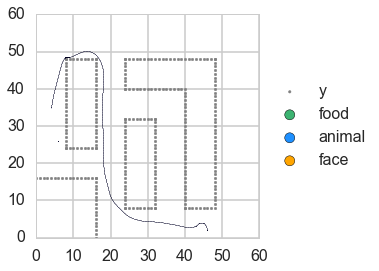

In [21]:
def plot_sub(subj, env, test_trial, rep):
    plot_paths(env=env, subj=subj, 
               dp=dp.loc[(dp['type'] == test_trial) &
                         (dp.rep == rep)], 
               proj=proj)
    
subj_opts = ipywidgets.Dropdown(options=list(dp.subid.unique()))
env_opts = ipywidgets.Dropdown(options=list(np.sort(dp.env.unique()[1:])))
test_opts = ipywidgets.Dropdown(options=list(['habit', 'shortcut']))
rep_opts = ipywidgets.IntSlider(min=1, max=2)

w = ipywidgets.interact(plot_sub, 
                        subj=subj_opts, 
                        env=env_opts, 
                        test_trial=test_opts, 
                        rep=rep_opts)